# ActFlow 2b -- Compute the baseline decodability of Motor responses (LINDEX v. LMID and RINDEX v. RMID)
## Using ActFlow, one to one, via ridge-FC

## Use SVM classifications to decode hand-specific responses
## Using Ciric-style postprocessing

## Takuya Ito
#### 12/13/2018

In [33]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import os
import multiprocessing as mp
import scipy.stats as stats
import nibabel as nib
import os
os.environ['OMP_NUM_THREADS'] = str(1)
import statsmodels.api as sm
import sklearn.svm as svm
import statsmodels.sandbox.stats.multicomp as mc
import sklearn
from sklearn.feature_selection import f_classif
import seaborn as sns
import h5py
os.sys.path.append('glmScripts/')
import taskGLMPipeline as tgp
import statsmodels.api as sm

sns.set_style("whitegrid")
plt.rcParams["font.family"] = "FreeSans"


In [34]:
# Excluding 084
subjNums = ['013','014','016','017','018','021','023','024','026','027','028','030','031','032','033',
            '034','035','037','038','039','040','041','042','043','045','046','047','048','049','050',
            '053','055','056','057','058','062','063','066','067','068','069','070','072','074','075',
            '076','077','081','085','086','087','088','090','092','093','094','095','097','098','099',
            '101','102','103','104','105','106','108','109','110','111','112','114','115','117','119',
            '120','121','122','123','124','125','126','127','128','129','130','131','132','134','135',
            '136','137','138','139','140','141']



basedir = '/projects3/SRActFlow/'

# Using final partition
networkdef = np.loadtxt('/projects3/NetworkDiversity/data/network_partition.txt')
networkorder = np.asarray(sorted(range(len(networkdef)), key=lambda k: networkdef[k]))
networkorder.shape = (len(networkorder),1)
# network mappings for final partition set
networkmappings = {'fpn':7, 'vis1':1, 'vis2':2, 'smn':3, 'aud':8, 'lan':6, 'dan':5, 'con':4, 'dmn':9, 
                   'pmulti':10, 'none1':11, 'none2':12}
networks = networkmappings.keys()

xticks = {}
reorderednetworkaffil = networkdef[networkorder]
for net in networks:
    netNum = networkmappings[net]
    netind = np.where(reorderednetworkaffil==netNum)[0]
    tick = np.max(netind)
    xticks[tick] = net

## General parameters/variables
nParcels = 360
nSubjs = len(subjNums)

glasserfile2 = '/projects/AnalysisTools/ParcelsGlasser2016/Q1-Q6_RelatedParcellation210.LR.CorticalAreas_dil_Colors.32k_fs_RL.dlabel.nii'
glasser2 = nib.load(glasserfile2).get_data()
glasser2 = np.squeeze(glasser2)

sortednets = np.sort(xticks.keys())
orderednetworks = []
for net in sortednets: orderednetworks.append(xticks[net])
    
networkpalette = ['royalblue','slateblue','paleturquoise','darkorchid','limegreen',
                  'lightseagreen','yellow','orchid','r','peru','orange','olivedrab']
networkpalette = np.asarray(networkpalette)

OrderedNetworks = ['VIS1','VIS2','SMN','CON','DAN','LAN','FPN','AUD','DMN','PMM','VMM','ORA']

# 0.0 Define functions for loading data

In [35]:
def loadMotorResponses(subj,hand='Right'):
    
    hands = {'Left':[0,1],'Right':[2,3]}

    x = tgp.loadTaskTiming(subj,'ALL')
    stimIndex = np.asarray(x['stimIndex'])
    ind = np.where(stimIndex=='motorResponse')[0]
    
    datadir = basedir + 'data/postProcessing/hcpPostProcCiric/'
    h5f = h5py.File(datadir + subj + '_glmOutput_data.h5','r')
    data = h5f['taskRegression/ALL_24pXaCompCorXVolterra_taskReg_betas_canonical'][:].copy()
    data = data[:,ind].copy()
    h5f.close()
    
    # Isolate hand responses
    hand_ind = hands[hand]
    data = data[:,hand_ind]
    
    return data

def loadRSFCMapping(subj,roi):
    fcdir = '/projects3/SRActFlow/data/results/ridgeFC/'
    filename = fcdir + 'TargetParcel' + str(roi) + '_RidgeFC.h5'
    h5f = h5py.File(filename,'r')
    fcmapping = h5f[subj]['sourceToTargetMapping'][:].copy()
    h5f.close()
    return fcmapping


## Load masks
def loadMask(roi,dilated=True):
    maskdir = basedir + 'data/results/surfaceMasks/'
    if dilated:
        maskfile = maskdir + 'GlasserParcel' + str(roi) + '_dilated_10mm.dscalar.nii'
    else:
        maskfile = maskdir + 'GlasserParcel' + str(roi) + '.dscalar.nii'
    maskdata = np.squeeze(nib.load(maskfile).get_data())
    
    return maskdata
        

# 1.0 Define functions for motor response decodings

In [36]:
from scipy.spatial.distance import cdist

def motorResponseDecodings(data, actflow_data, rois, ncvs=1, nproc=5):
    """
    Run an across-subject classification
    Decode responses on each hand separately from CPRO data
    """

    nSubjs = data.shape[2]
    stats = np.zeros((len(rois),))
    
    nfing = data.shape[1]

    nsamples = nSubjs * nfing

    # Label array for supervised learning
    labels = np.tile(range(nfing),nSubjs)
    subjarray = np.repeat(range(nSubjs),nfing)

    # Run SVM classifications on network-level activation patterns across subjects
    roicount = 0
    for roi in rois:
        roi_ind = np.where(glasser2==roi)[0]
        nfeatures = len(roi_ind)
        roi_ind.shape = (len(roi_ind),1)       

        svm_mat = np.zeros((nsamples,roi_ind.shape[0]))
        actflow_svm_mat = np.zeros((nsamples,roi_ind.shape[0]))
        samplecount = 0
        scount = 0
        for subj in range(len(subjNums)):
            roidata = np.squeeze(data[roi_ind,:,scount])
            actflow_roidata = np.squeeze(actflow_data[roi_ind,:,scount])
            svm_mat[samplecount:(samplecount+nfing),:] = roidata.T
            actflow_svm_mat[samplecount:(samplecount+nfing),:] = actflow_roidata.T

            scount += 1
            samplecount += nfing

            # Spatially demean matrix across features
            samplemean = np.mean(svm_mat,axis=1)
            samplemean.shape = (len(samplemean),1)
            svm_mat = svm_mat - samplemean
            
            samplemean = np.mean(actflow_svm_mat,axis=1)
            samplemean.shape = (len(samplemean),1)
            actflow_svm_mat = actflow_svm_mat - samplemean

        scores = randomSplitLOOBaselineCV(ncvs, svm_mat, actflow_svm_mat, labels, subjarray, nproc=nproc)
        stats[roicount] = np.mean(scores)
        roicount += 1
        
    return stats

def randomSplitLOOBaselineCV(ncvs, svm_mat, actflow_svm_mat, labels, subjarray, nproc=5):
    """
    Runs cross validation for an across-subject SVM analysis
    """
    
    ntasks = len(np.unique(labels))
    nsamples = svm_mat.shape[0]
    nsubjs = nsamples/ntasks

    subjects = np.unique(subjarray)
    indices = np.arange(nsamples)
    
    numsubjs_perfold = 1
    if nsubjs%numsubjs_perfold!=0: 
        raise Exception("Error: Folds don't match number of subjects")
        
    nfolds = nsubjs/numsubjs_perfold
    subj_array_folds = subjarray.copy()
    
    inputs = [] 
    
    for fold in range(nfolds):
        test_subjs = np.random.choice(subj_array_folds,numsubjs_perfold,replace=False)
        train_subjs_all = np.delete(subjects,test_subjs)
        for cv in range(ncvs):
            # Randomly sample half of train set subjects for each cv (CV bootstrapping)
            train_subjs = np.random.choice(train_subjs_all,
                                         int(np.floor(len(train_subjs_all)*(4.0))),
                                         replace=True)

            train_ind = []
            for subj in train_subjs:
                train_ind.extend(np.where(subjarray==subj)[0])

            test_ind = []
            for subj in test_subjs:
                test_ind.extend(np.where(subjarray==subj)[0])
            
            train_ind = np.asarray(train_ind)
            test_ind = np.asarray(test_ind)

            trainset = actflow_svm_mat[train_ind,:]
            testset = svm_mat[test_ind,:]
            orig_training = svm_mat[train_ind,:]

            # Normalize trainset and testset
            trainmean = np.mean(actflow_svm_mat[train_ind,:],axis=0)
            trainmean.shape = (1,len(trainmean))
            trainstd = np.std(actflow_svm_mat[train_ind,:],axis=0)
            trainstd.shape = (1,len(trainstd))
            
            # Normalize trainset and testset
            testmean = np.mean(svm_mat[train_ind,:],axis=0)
            testmean.shape = (1,len(testmean))
            teststd = np.std(svm_mat[train_ind,:],axis=0)
            teststd.shape = (1,len(teststd))

            trainset = np.divide((trainset - trainmean),trainstd)
            testset = np.divide((testset - testmean),teststd)

            ######## FEATURE SELECTION & REDUCTION
            ## Feature selection and downsampling
            trainlabels = labels[train_ind]
            testlabels = labels[test_ind]
            unique_labels = np.unique(labels)
            feat1_labs = np.where(trainlabels==0)[0]
            feat2_labs = np.where(trainlabels==1)[0]
            # Perform t-test
            t, p = stats.ttest_rel(orig_training[feat1_labs,:],orig_training[feat2_labs,:],axis=0)
            h0, qs = mc.fdrcorrection0(p)
            # Construct feature masks
            feat1_mask = np.multiply(t<0,h0)
            feat2_mask = np.multiply(t>0,h0)
#             feat1_mask = t>0
#             feat2_mask = t<0
            # Downsample training set into original vertices into 2 ROI signals
            trainset_downsampled = np.zeros((trainset.shape[0],2))
            trainset_downsampled[:,0] = np.nanmean(trainset[:,feat1_mask],axis=1)
            trainset_downsampled[:,1] = np.nanmean(trainset[:,feat2_mask],axis=1)
            trainset_downsampled = trainset[:,h0]
            # Downsample test set into original vertices
            testset_downsampled = np.zeros((testset.shape[0],2))
            testset_downsampled[:,0] = np.nanmean(testset[:,feat1_mask],axis=1)
            testset_downsampled[:,1] = np.nanmean(testset[:,feat2_mask],axis=1)
            testset_downsampled = testset[:,h0]
#             print 'feat1_mask', np.sum(feat1_mask), '| feat2_mask', np.sum(feat2_mask)

            if np.sum(feat1_mask)==0 or np.sum(feat2_mask)==0:
                print 'not running feature selection'
                inputs.append((trainset,testset,labels[train_ind],labels[test_ind]))
            else:
                inputs.append((trainset_downsampled,testset_downsampled,labels[train_ind],labels[test_ind]))

#             inputs.append((trainset,testset,labels[train_ind],labels[test_ind]))         
    
        subj_array_folds = np.delete(subj_array_folds,test_subjs)
        
    pool = mp.Pool(processes=nproc)
    scores = pool.map_async(_decoding,inputs).get()
    pool.close()
    pool.join()

    acc = []
    for score in scores:
        acc.extend(score)
    return acc

def _decoding((trainset,testset,trainlabels,testlabels)):

#     clf = sklearn.linear_model.LogisticRegression()
#     clf = svm.SVC(C=1.0, kernel='linear')

#     clf.fit(trainset,trainlabels)
#     predictions = clf.predict(testset)
#     acc = predictions==testlabels
    
    unique_cond = np.unique(trainlabels)
    acc = []
    for cond1 in unique_cond:
        mismatches = []
        prototype_ind = np.where(trainlabels==cond1)[0]
        prototype = np.mean(trainset[prototype_ind,:],axis=0)
        for cond2 in unique_cond:
            test_ind = np.where(testlabels==cond2)[0]
            test = np.mean(testset[test_ind,:],axis=0)
            if cond1 == cond2: 
                correct = stats.spearmanr(prototype,test)[0]
            else:
                mismatches.append(stats.spearmanr(prototype,test)[0])
#         print correct, mismatches
        if correct > np.max(mismatches): 
            acc.append(1.0)
        else:
            acc.append(0.0)
    
    return acc

## 0.1 Load data for RH responses

In [37]:
# gsr = True
nResponses = 2
data_task = np.zeros((len(glasser2),nResponses,len(subjNums)))

scount = 0
for subj in subjNums:
    data_task[:,:,scount] = loadMotorResponses(subj,hand='Right')
    scount += 1

## 0.2 Generate actflow data for RH responses (Left S1)

In [38]:
roi_rh = 9 #left S1
target_rh_ind = np.where(glasser2==roi_rh)[0]
fcmapping_rh = np.zeros((len(glasser2),len(target_rh_ind)))

scount = 0
for subj in subjNums:
    fcmapping_rh[:,:] = fcmapping_rh[:,:] + loadRSFCMapping(subj,roi_rh)
    scount += 1

fcmapping_rh = np.divide(fcmapping_rh,len(subjNums))

In [39]:
roi_rh = 9 # left s1
roi_lh = 189 # right s1
actflow_data = np.zeros((len(glasser2),nResponses,len(subjNums),nParcels))

dilateLH = loadMask(roi_lh,dilated=True)
dilateRH = loadMask(roi_rh,dilated=True)
combinedDilated = dilateLH + dilateRH
source_space = np.where(combinedDilated==0)[0]
bad_rois = []
scount = 0
for subj in subjNums:
    print 'Subject', subj, '(', scount+1, '/', len(subjNums), ')'
    for roi in range(nParcels):
        source_ind = np.where(glasser2==roi+1)[0]
        source_ind = np.intersect1d(source_ind,source_space) # Make sure no vertices are within 10mm of the target
        if source_ind.shape[0]==0:
#             print 'This source has no vertices, skipping'
            bad_rois.append(roi)
            continue
        
        target_ind = np.where(glasser2==roi_rh)[0]
        # Right Finger 1
        actflow_data[target_ind,0,scount,roi] = np.dot(stats.zscore(data_task[source_ind,0,scount],axis=0),fcmapping_rh[source_ind,:])
        # Right Finger 2
        actflow_data[target_ind,1,scount,roi] = np.dot(stats.zscore(data_task[source_ind,1,scount],axis=0),fcmapping_rh[source_ind,:])

    scount += 1
    

Subject 013 ( 1 / 96 )
Subject 014 ( 2 / 96 )
Subject 016 ( 3 / 96 )
Subject 017 ( 4 / 96 )
Subject 018 ( 5 / 96 )
Subject 021 ( 6 / 96 )
Subject 023 ( 7 / 96 )
Subject 024 ( 8 / 96 )
Subject 026 ( 9 / 96 )
Subject 027 ( 10 / 96 )
Subject 028 ( 11 / 96 )
Subject 030 ( 12 / 96 )
Subject 031 ( 13 / 96 )
Subject 032 ( 14 / 96 )
Subject 033 ( 15 / 96 )
Subject 034 ( 16 / 96 )
Subject 035 ( 17 / 96 )
Subject 037 ( 18 / 96 )
Subject 038 ( 19 / 96 )
Subject 039 ( 20 / 96 )
Subject 040 ( 21 / 96 )
Subject 041 ( 22 / 96 )
Subject 042 ( 23 / 96 )
Subject 043 ( 24 / 96 )
Subject 045 ( 25 / 96 )
Subject 046 ( 26 / 96 )
Subject 047 ( 27 / 96 )
Subject 048 ( 28 / 96 )
Subject 049 ( 29 / 96 )
Subject 050 ( 30 / 96 )
Subject 053 ( 31 / 96 )
Subject 055 ( 32 / 96 )
Subject 056 ( 33 / 96 )
Subject 057 ( 34 / 96 )
Subject 058 ( 35 / 96 )
Subject 062 ( 36 / 96 )
Subject 063 ( 37 / 96 )
Subject 066 ( 38 / 96 )
Subject 067 ( 39 / 96 )
Subject 068 ( 40 / 96 )
Subject 069 ( 41 / 96 )
Subject 070 ( 42 / 96 )
S

## 1.1 Run across subject decoding on right-hand motor responses

In [40]:
nproc = 20
ncvs = 1

rois = np.where(networkdef==networkmappings['smn'])[0] + 1
rois = [9] # Left S1


# sourceROIs = []
# sourceROIs.extend(np.where(networkdef==networkmappings['fpn'])[0])
# sourceROIs.extend(np.where(networkdef==networkmappings['dan'])[0])
# sourceROIs.extend(np.where(networkdef==networkmappings['con'])[0])
sourceROIs = np.where(networkdef!=networkmappings['smn'])[0]

distances_baseline_rh = np.zeros((nParcels,len(subjNums)*2))
for roi in sourceROIs:
    print 'Decoding roi', roi
#     if roi in bad_rois: 
#         continue

    distances_baseline_rh[roi,:] = motorResponseDecodings(data_task,
                                                          actflow_data[:,:,:,roi],
                                                          rois=rois, ncvs=ncvs, nproc=nproc)
    

Decoding roi 0
Decoding roi 1
Decoding roi 2
Decoding roi 3
Decoding roi 4
Decoding roi 5
Decoding roi 6
Decoding roi 9
Decoding roi 10
Decoding roi 11
Decoding roi 12
Decoding roi 13
Decoding roi 14
Decoding roi 15
Decoding roi 16
Decoding roi 17
Decoding roi 18
Decoding roi 19
Decoding roi 20
Decoding roi 21
Decoding roi 22
Decoding roi 23
Decoding roi 24
Decoding roi 25
Decoding roi 26
Decoding roi 27
Decoding roi 28
Decoding roi 29
Decoding roi 30
Decoding roi 31
Decoding roi 32
Decoding roi 33
Decoding roi 34
Decoding roi 36
Decoding roi 37
Decoding roi 42
Decoding roi 43
Decoding roi 44
Decoding roi 45
Decoding roi 47
Decoding roi 48
Decoding roi 49
Decoding roi 56
Decoding roi 57
Decoding roi 58
Decoding roi 59
Decoding roi 60
Decoding roi 61
Decoding roi 62
Decoding roi 63
Decoding roi 64
Decoding roi 65
Decoding roi 66
Decoding roi 67
Decoding roi 68
Decoding roi 69
Decoding roi 70
Decoding roi 71
Decoding roi 72
Decoding roi 73
Decoding roi 74
Decoding roi 75
Decoding roi 76


## 1.2 Compute statistics

In [63]:
statistics_rh = np.zeros((distances_baseline_rh.shape[0],3))
for roicount in range(distances_baseline_rh.shape[0]):
    ntrials = len(subjNums)*2
    p = stats.binom_test(np.mean(distances_baseline_rh[roicount,:])*ntrials,n=ntrials,p=0.5)
    if np.mean(distances_baseline_rh[roicount,:])>0.5:
        p = p/2.0
    else:
        p = 1.0-p/2.0

    statistics_rh[roicount,0] = np.mean(distances_baseline_rh[roicount,:])
    statistics_rh[roicount,1] = p

# rois_testing = []
# rois_testing.extend(np.where(networkdef==networkmappings['fpn'])[0])
# rois_testing.extend(np.where(networkdef==networkmappings['con'])[0])
# rois_testing.extend(np.where(networkdef==networkmappings['dan'])[0])
rois_testing = np.where(networkdef!=networkmappings['smn'])[0]
h0, qs = mc.fdrcorrection0(statistics_rh[rois_testing,1])
h0 = (statistics_rh[rois_testing,1]*len(rois_testing))<0.05
statistics_rh[:,1] = 1.0
i = 0
for roi in rois_testing:
    statistics_rh[roi,1] = qs[i]
    statistics_rh[roi,2] = h0[i]*statistics_rh[roi,0]
    i += 1
        
nSignificant = np.sum(statistics_rh[:,1] < 0.05)
print 'Number of significant transfers:', nSignificant

if nSignificant>0:
    sig_ind = np.where(statistics_rh[:,1]<0.05)[0]
    print 'Number of significant effects', nSignificant
    print 'Left hemisphere effects:', np.sum(sig_ind<180)
    print 'Right hemisphere effects:', np.sum(sig_ind>180)
    for ind in sig_ind:
        print '\tSignificant parcel:', ind+1
        print '\tAccuracy:', statistics_rh[ind,0]
        print '\tNetwork:', networkdef[ind]
print 'Network mappings:', networkmappings

Number of significant transfers: 107
Number of significant effects 107
Left hemisphere effects: 57
Right hemisphere effects: 49
	Significant parcel: 2
	Accuracy: 0.729166666667
	Network: 2.0
	Significant parcel: 11
	Accuracy: 0.645833333333
	Network: 5.0
	Significant parcel: 24
	Accuracy: 0.677083333333
	Network: 8.0
	Significant parcel: 30
	Accuracy: 0.625
	Network: 9.0
	Significant parcel: 32
	Accuracy: 0.645833333333
	Network: 9.0
	Significant parcel: 35
	Accuracy: 0.59375
	Network: 9.0
	Significant parcel: 37
	Accuracy: 0.697916666667
	Network: 4.0
	Significant parcel: 43
	Accuracy: 0.635416666667
	Network: 4.0
	Significant parcel: 44
	Accuracy: 0.59375
	Network: 4.0
	Significant parcel: 48
	Accuracy: 0.75
	Network: 2.0
	Significant parcel: 49
	Accuracy: 0.75
	Network: 2.0
	Significant parcel: 57
	Accuracy: 0.635416666667
	Network: 4.0
	Significant parcel: 59
	Accuracy: 0.885416666667
	Network: 4.0
	Significant parcel: 65
	Accuracy: 0.59375
	Network: 9.0
	Significant parcel: 70
	Ac

## 3.3 Map accuracies back to cortical surface

In [62]:
# Put all data into a single matrix (since we only run a single classification)
sourceToSMN = np.zeros((glasser2.shape[0],3))

roicount = 0
for roi in rois_testing:
    vertex_ind = np.where(glasser2==roi+1)[0]
    sourceToSMN[vertex_ind,0] = statistics_rh[roicount,0]
    sourceToSMN[vertex_ind,1] = statistics_rh[roicount,1]
    sourceToSMN[vertex_ind,2] = statistics_rh[roicount,2]

    roicount += 1

    
#### 
# Write file to csv and run wb_command
outdir = '/projects3/SRActFlow/data/results/ActFlowDecoding_OneToOne_RidgeFC/'
filename = 'RH_ActFlowDecoding_OneToOne_RidgeFCDecoding'
np.savetxt(outdir + filename + '.csv', sourceToSMN,fmt='%s')
wb_file = filename + '.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)




0

# Generate ActFlow predictions for the Left Hand (Right S1)

## 0.1 Load data for LH responses

In [42]:
# gsr = True
nResponses = 2
data_task = np.zeros((len(glasser2),nResponses,len(subjNums)))

scount = 0
for subj in subjNums:
    data_task[:,:,scount] = loadMotorResponses(subj,hand='Left')
    scount += 1

## 0.2 Generate actflow data for LH responses (Right S1)

In [43]:
roi_lh = 189 #left S1
target_lh_ind = np.where(glasser2==roi_lh)[0]
fcmapping_lh = np.zeros((len(glasser2),len(target_lh_ind)))

scount = 0
for subj in subjNums:
    fcmapping_lh[:,:] = fcmapping_lh[:,:] + loadRSFCMapping(subj,roi_lh)
    scount += 1

fcmapping_lh = np.divide(fcmapping_lh,len(subjNums))

In [44]:
roi_rh = 9 # left s1
roi_lh = 189 # right s1
actflow_data = np.zeros((len(glasser2),nResponses,len(subjNums),nParcels))

dilateLH = loadMask(roi_lh,dilated=True)
dilateRH = loadMask(roi_rh,dilated=True)
combinedDilated = dilateLH + dilateRH
source_space = np.where(combinedDilated==0)[0]
bad_rois = []
scount = 0
for subj in subjNums:
    print 'Subject', subj, '(', scount+1, '/', len(subjNums), ')'
    for roi in range(nParcels):
        source_ind = np.where(glasser2==roi+1)[0]
        source_ind = np.intersect1d(source_ind,source_space) # Make sure no vertices are within 10mm of the target
        if source_ind.shape[0]==0:
#             print 'This source has no vertices, skipping'
            bad_rois.append(roi)
            continue
        
        target_ind = np.where(glasser2==roi_lh)[0]
        # Right Finger 1
        actflow_data[target_ind,0,scount,roi] = np.dot(stats.zscore(data_task[source_ind,0,scount],axis=0),fcmapping_lh[source_ind,:])
        # Right Finger 2
        actflow_data[target_ind,1,scount,roi] = np.dot(stats.zscore(data_task[source_ind,1,scount],axis=0),fcmapping_lh[source_ind,:])

    scount += 1
    

Subject 013 ( 1 / 96 )
Subject 014 ( 2 / 96 )
Subject 016 ( 3 / 96 )
Subject 017 ( 4 / 96 )
Subject 018 ( 5 / 96 )
Subject 021 ( 6 / 96 )
Subject 023 ( 7 / 96 )
Subject 024 ( 8 / 96 )
Subject 026 ( 9 / 96 )
Subject 027 ( 10 / 96 )
Subject 028 ( 11 / 96 )
Subject 030 ( 12 / 96 )
Subject 031 ( 13 / 96 )
Subject 032 ( 14 / 96 )
Subject 033 ( 15 / 96 )
Subject 034 ( 16 / 96 )
Subject 035 ( 17 / 96 )
Subject 037 ( 18 / 96 )
Subject 038 ( 19 / 96 )
Subject 039 ( 20 / 96 )
Subject 040 ( 21 / 96 )
Subject 041 ( 22 / 96 )
Subject 042 ( 23 / 96 )
Subject 043 ( 24 / 96 )
Subject 045 ( 25 / 96 )
Subject 046 ( 26 / 96 )
Subject 047 ( 27 / 96 )
Subject 048 ( 28 / 96 )
Subject 049 ( 29 / 96 )
Subject 050 ( 30 / 96 )
Subject 053 ( 31 / 96 )
Subject 055 ( 32 / 96 )
Subject 056 ( 33 / 96 )
Subject 057 ( 34 / 96 )
Subject 058 ( 35 / 96 )
Subject 062 ( 36 / 96 )
Subject 063 ( 37 / 96 )
Subject 066 ( 38 / 96 )
Subject 067 ( 39 / 96 )
Subject 068 ( 40 / 96 )
Subject 069 ( 41 / 96 )
Subject 070 ( 42 / 96 )
S

## 1.1 Run across subject decoding on left-hand motor responses

In [45]:
nproc = 20
ncvs = 1

rois = np.where(networkdef==networkmappings['smn'])[0] + 1
rois = [189] # Left S1


# sourceROIs = []
# sourceROIs.extend(np.where(networkdef==networkmappings['fpn'])[0])
# sourceROIs.extend(np.where(networkdef==networkmappings['dan'])[0])
# sourceROIs.extend(np.where(networkdef==networkmappings['con'])[0])
sourceROIs = np.where(networkdef!=networkmappings['smn'])[0]


distances_baseline_lh = np.zeros((nParcels,len(subjNums)*2))
for roi in sourceROIs:
    print 'Decoding roi', roi
#     if roi in bad_rois: 
#         continue

    distances_baseline_lh[roi,:] = motorResponseDecodings(data_task, 
                                                          actflow_data[:,:,:,roi],
                                                          rois=rois, ncvs=ncvs, nproc=nproc)
    

Decoding roi 0
Decoding roi 1
Decoding roi 2
Decoding roi 3
Decoding roi 4
Decoding roi 5
Decoding roi 6
Decoding roi 9
Decoding roi 10
Decoding roi 11
Decoding roi 12
Decoding roi 13
Decoding roi 14
Decoding roi 15
Decoding roi 16
Decoding roi 17
Decoding roi 18
Decoding roi 19
Decoding roi 20
Decoding roi 21
Decoding roi 22
Decoding roi 23
Decoding roi 24
Decoding roi 25
Decoding roi 26
Decoding roi 27
Decoding roi 28
Decoding roi 29
Decoding roi 30
Decoding roi 31
Decoding roi 32
Decoding roi 33
Decoding roi 34
Decoding roi 36
Decoding roi 37
Decoding roi 42
Decoding roi 43
Decoding roi 44
Decoding roi 45
Decoding roi 47
Decoding roi 48
Decoding roi 49
Decoding roi 56
Decoding roi 57
Decoding roi 58
Decoding roi 59
Decoding roi 60
Decoding roi 61
Decoding roi 62
Decoding roi 63
Decoding roi 64
Decoding roi 65
Decoding roi 66
Decoding roi 67
Decoding roi 68
Decoding roi 69
Decoding roi 70
Decoding roi 71
Decoding roi 72
Decoding roi 73
Decoding roi 74
Decoding roi 75
Decoding roi 76


## 1.2 Compute statistics

In [66]:
statistics_lh = np.zeros((distances_baseline_lh.shape[0],3))
for roicount in range(distances_baseline_lh.shape[0]):
    ntrials = len(subjNums)*2
    p = stats.binom_test(np.mean(distances_baseline_lh[roicount,:])*ntrials,n=ntrials,p=0.5)
    if np.mean(distances_baseline_lh[roicount,:])>0.5:
        p = p/2.0
    else:
        p = 1.0-p/2.0

    statistics_lh[roicount,0] = np.mean(distances_baseline_lh[roicount,:])
    statistics_lh[roicount,1] = p

# rois_testing = []
# rois_testing.extend(np.where(networkdef==networkmappings['fpn'])[0])
# rois_testing.extend(np.where(networkdef==networkmappings['con'])[0])
# rois_testing.extend(np.where(networkdef==networkmappings['dan'])[0])
rois_testing = np.where(networkdef!=networkmappings['smn'])[0]

h0, qs = mc.fdrcorrection0(statistics_lh[rois_testing,1])
statistics_lh[:,1] = 1.0
i = 0
for roi in rois_testing:
    statistics_lh[roi,1] = qs[i]
    statistics_lh[roi,2] = h0[i]*statistics_lh[roi,0]
    i += 1
        
nSignificant = np.sum(statistics_lh[:,1] < 0.05)
print 'Number of significant transfers:', nSignificant

if nSignificant>0:
    sig_ind = np.where(statistics_lh[:,1]<0.05)[0]
    print 'Number of significant effects', nSignificant
    print 'Left hemisphere effects:', np.sum(sig_ind<180)
    print 'Right hemisphere effects:', np.sum(sig_ind>180)
    for ind in sig_ind:
        print '\tSignificant parcel:', ind+1
        print '\tAccuracy:', statistics_lh[ind,0]
        print '\tNetwork:', networkdef[ind]
print 'Network mappings:', networkmappings

Number of significant transfers: 94
Number of significant effects 94
Left hemisphere effects: 47
Right hemisphere effects: 47
	Significant parcel: 5
	Accuracy: 0.71875
	Network: 2.0
	Significant parcel: 16
	Accuracy: 0.770833333333
	Network: 2.0
	Significant parcel: 20
	Accuracy: 0.625
	Network: 2.0
	Significant parcel: 23
	Accuracy: 0.59375
	Network: 2.0
	Significant parcel: 24
	Accuracy: 0.697916666667
	Network: 8.0
	Significant parcel: 26
	Accuracy: 0.791666666667
	Network: 6.0
	Significant parcel: 31
	Accuracy: 0.75
	Network: 9.0
	Significant parcel: 50
	Accuracy: 0.625
	Network: 5.0
	Significant parcel: 57
	Accuracy: 0.645833333333
	Network: 4.0
	Significant parcel: 62
	Accuracy: 0.75
	Network: 9.0
	Significant parcel: 66
	Accuracy: 0.802083333333
	Network: 9.0
	Significant parcel: 69
	Accuracy: 0.697916666667
	Network: 9.0
	Significant parcel: 74
	Accuracy: 0.739583333333
	Network: 6.0
	Significant parcel: 77
	Accuracy: 0.604166666667
	Network: 7.0
	Significant parcel: 78
	Accura

## 3.3 Map accuracies back to cortical surface

In [65]:
# Put all data into a single matrix (since we only run a single classification)
sourceToSMN = np.zeros((glasser2.shape[0],3))

roicount = 0
for roi in rois_testing:
    vertex_ind = np.where(glasser2==roi+1)[0]
    sourceToSMN[vertex_ind,0] = statistics_lh[roicount,0]
    sourceToSMN[vertex_ind,1] = statistics_lh[roicount,1]
    sourceToSMN[vertex_ind,2] = statistics_lh[roicount,2]

    roicount += 1

    
#### 
# Write file to csv and run wb_command
outdir = '/projects3/SRActFlow/data/results/ActFlowDecoding_OneToOne_RidgeFC/'
filename = 'LH_ActFlowDecoding_OneToOne_RidgeFCDecoding'
np.savetxt(outdir + filename + '.csv', sourceToSMN,fmt='%s')
wb_file = filename + '.dscalar.nii'
wb_command = 'wb_command -cifti-convert -from-text ' + outdir + filename + '.csv ' + glasserfile2 + ' ' + outdir + wb_file + ' -reset-scalars'
os.system(wb_command)




0

In [92]:
tmp_rois.shape

(321,)

In [95]:
tmp_lh.shape

(360,)

-1.09127813068 0.276302383307
Correlate the two decodings
Differences in target decodings for left and right hand responses:
	Correlation = 0.044930426565 | p = 0.49869672917


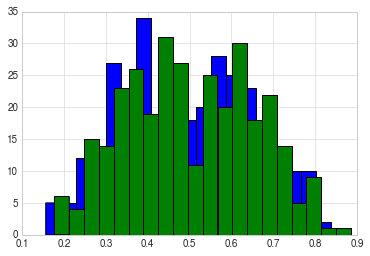

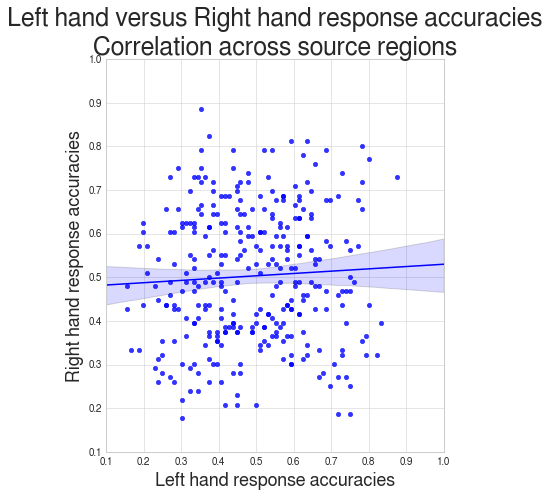

In [105]:
plt.hist(statistics_lh[rois_testing,0],bins=20,label='Left hand decodings')
plt.hist(statistics_rh[rois_testing,0],bins=20,label='Right hand decodings')
# t, p = stats.ttest_rel(statistics_lh[rois_testing,0],statistics_rh[rois_testing,0])
tmp_lh = (statistics_lh[:,1]<0.025) | (statistics_lh[:,1]>0.975)
tmp_rh = (statistics_rh[:,1]<0.025) | (statistics_rh[:,1]>0.975)

tmp_rois = np.multiply(tmp_rh,tmp_lh)
smn_ind = np.where(networkdef==networkmappings['smn'])[0]
tmp_rois[smn_ind] = False
t, p = stats.ttest_rel(statistics_lh[tmp_rois,0],statistics_rh[tmp_rois,0])
print t, p

print 'Correlate the two decodings'
rho, p = stats.pearsonr(statistics_lh[tmp_rois,0],statistics_rh[tmp_rois,0])
print 'Differences in target decodings for left and right hand responses:'
print '\tCorrelation =', rho, '| p =', p

plt.figure(figsize=(7,7))
sns.regplot(statistics_lh[rois_testing,0],statistics_rh[rois_testing,0])
plt.title('Left hand versus Right hand response accuracies\nCorrelation across source regions',fontsize=25)
plt.xlabel('Left hand response accuracies',fontsize=18)
plt.ylabel('Right hand response accuracies',fontsize=18)
plt.tight_layout()
# plt.savefig('LH_vs_RH_sourceRegionPredictions.pdf')